In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, classification_report

sys.path.append('../..')

from seismicpro.batchflow import Pipeline, Dataset, B, V
from seismicpro.batchflow.models.torch import ResNet18, VGG7
from seismicpro.src import TraceIndex, SeismicDataset, FieldIndex, KNNIndex
from seismicpro.src.seismic_batch import (SeismicBatch,
                                            seismic_plot)
from inverse_batch import predict
%env CUDA_VISIBLE_DEVICES=5

env: CUDA_VISIBLE_DEVICES=5


In [94]:
from seismicpro.batchflow import action, inbatch_parallel

class InverseBatch_2d(SeismicBatch):
    @action
    @inbatch_parallel(init='_init_component')
    def inv_traces(self, index, src, dst, p=.5):
        pos = self.get_pos(None, src, index)
        traces = getattr(self, src)[pos]
        size = traces.shape[0]
        mask = np.random.choice([1, -1], size=size, p=(1-p, p))

        getattr(self, dst[0])[pos] = traces * mask.reshape(-1, 1)
        getattr(self, dst[1])[pos] = 1 - np.clip(mask, 0, 1)

    @action
    def preprocess_component(self, src, dst):
        """Prepeare data for loading into torch models."""
        data = getattr(self, src)
        data_st = np.stack(data)
        data_st = np.expand_dims(data_st, axis=1)
        setattr(self, dst, data_st.astype(np.float32))
        return self
    
    @action
    def preprocess_answers(self, src, dst):
        data = getattr(self, src)
        data_st = np.stack(data)
        setattr(self, dst, data_st.astype(np.float32))
        return self

    @action
    @inbatch_parallel(init='_init_component')
    def crop_trace(self, index, src, dst, size=200):
        pos = self.get_pos(None, src[0], index)
        trace = getattr(self, src[0])[pos]
        picking = getattr(self, src[1])[pos]

        lenght = len(trace.ravel())
        if lenght < picking + int(size/2):
            left = lenght - size
            right = lenght
        elif picking - int(size/2) < 0:
            left = 0
            right = size
        else:
            left = picking - int(size/2)
            right = picking + int(size/2)
        left = np.clip(left, 0, lenght)
        right = np.clip(right, 0, lenght)
        getattr(self, dst)[pos] = np.array(trace[0][left: right].reshape(1, -1))

In [127]:
pal_path = '/data/FB/dataset_1/Pal_Flatiron_1k.sgy'
wz_path = '/data/FB/dataset_2/WZ_Flatiron_1k.sgy'
var_path = '/data/FB/dataset_6/3_FBP_input_ffid_raw-500_off-800.sgy'

pal_index = KNNIndex(name='raw', path=pal_path, extra_headers=['offset'], n_neighbors=3)
pal_index = pal_index.create_subset(pal_index.indices[:100000])
pal_index.split()
pal_data_tr = Dataset(pal_index.train, InverseBatch_2d)
pal_data_te = Dataset(pal_index.test, InverseBatch_2d)

wz_index = KNNIndex(name='raw', path=wz_path, extra_headers=['offset'], n_neighbors=3)
wz_index = wz_index.create_subset(wz_index.indices[:100000])
wz_index.split()
wz_data_tr = Dataset(wz_index.train, InverseBatch_2d)
wz_data_te = Dataset(wz_index.test, InverseBatch_2d)

In [128]:
prep_ppl = (Pipeline()
          .load(components='raw', fmt='segy')
          .standardize(src='raw', dst='raw')
          .inv_traces(src='raw', dst=['raw', 'labels'], p=0.1)
          .preprocess_component(src='raw', dst='raw')            
          .preprocess_answers(src='labels', dst='labels')
)

In [170]:
SIZE = 751
inputs_config = {
    'raw': {'shape': (1, 3, SIZE)}, 
    'masks': {'shape': (3, )}
    }

config = {
    'loss': 'bce',
    'inputs': inputs_config,
    'initial_block/inputs': 'raw',
    'optimizer': ('SGD', {'lr': 0.005, 'momentum':0.99}),
    'n_iters': 109.5425,
    'decay': dict(name='exp', gamma=0.99),
   'device': 'gpu:0',
}

In [171]:
train_ppl = prep_ppl + (Pipeline()
             .init_model('dynamic', ResNet18, 'model', config)
             .init_variable('loss', init_on_each_run=list)
             .train_model('model', B('raw'), B('labels'),  
                          fetches='loss', save_to=V('loss', mode='a'))
)

In [230]:
def create_test_ppl(train_ppl, data):
    test_ppl = (Pipeline().load(components='raw', fmt='segy')
              .standardize(src='raw', dst='raw')
              .inv_traces(src='raw', dst=['raw', 'labels'], p=0.001)
              .import_model('model', train_ppl, 'model')
              .preprocess_component(src='raw', dst='raw')
              .preprocess_answers(src='labels', dst='labels')
              .init_variable('pred', init_on_each_run=list())
              .init_variable('labels', init_on_each_run=list())
              .update_variable('labels', B('labels'), mode='e') 
              .predict_model('model', B('raw'), fetches='predictions',
                             save_to=V('pred', mode='e'))) << data
    return test_ppl

In [231]:
import torch
from sklearn.metrics import f1_score

In [232]:
from IPython.display import clear_output
from tqdm import tqdm

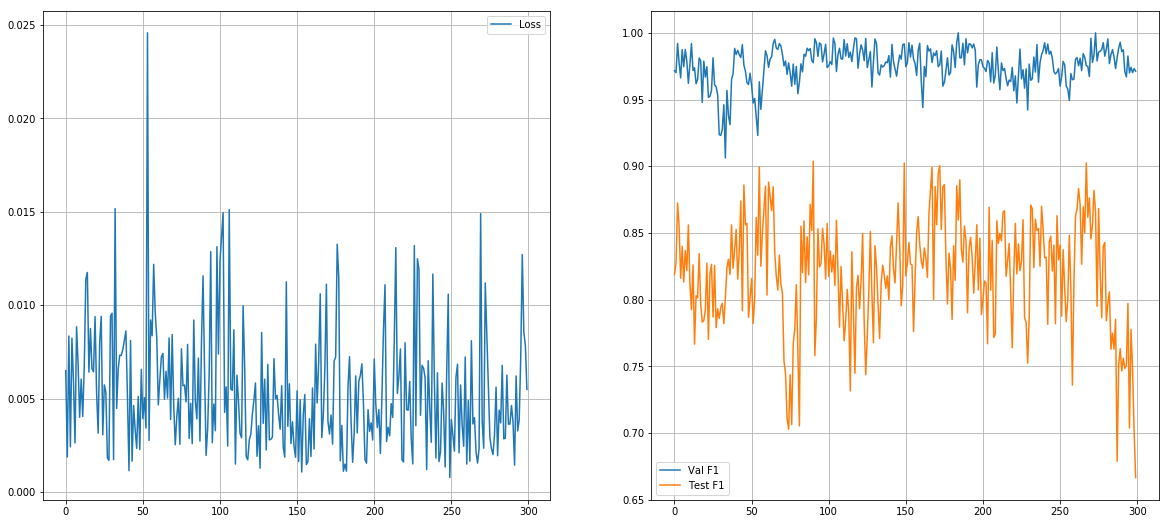



 20%|█▉        | 1950/10000 [1:44:50<7:07:51,  3.19s/it]

In [ ]:
ppl_train = (train_ppl << pal_data_tr)
ppl_val = create_test_ppl(ppl_train, pal_data_te)
ppl_test = create_test_ppl(ppl_train, wz_data_te)
sigm = torch.nn.Sigmoid()
val_score = []
test_score = []
for i in tqdm(range(10000)):
    ppl_train.next_batch(400, shuffle=True, drop_last=True)
    ppl_val.next_batch(400, shuffle=True, drop_last=True)
    ppl_test.next_batch(400, shuffle=True, drop_last=True)
    
    val_pred = sigm(torch.Tensor(ppl_val.v('pred')))
    test_pred = sigm(torch.Tensor(ppl_test.v('pred')))
    
    preds_val = np.array(val_pred > .5, dtype=int)
    labels_val = (ppl_val.v('labels'))
    
    preds_test = np.array(test_pred > .5, dtype=int)
    labels_test = (ppl_test.v('labels'))

    val_score.append(f1_score(labels_val.ravel(), preds_val.ravel()))
    test_score.append(f1_score(labels_test.ravel(), preds_test.ravel()))
    clear_output()
    _, ax = plt.subplots(1, 2, figsize=(20, 9))
    ax[0].plot(ppl_train.v('loss')[-300:], label='Loss')
    ax[1].plot(val_score[-300:], label='Val F1')
    ax[1].plot(test_score[-300:], label='Test F1')
    ax[0].legend()
    ax[1].legend()
    ax[0].grid()
    ax[1].grid()
    plt.show()
    

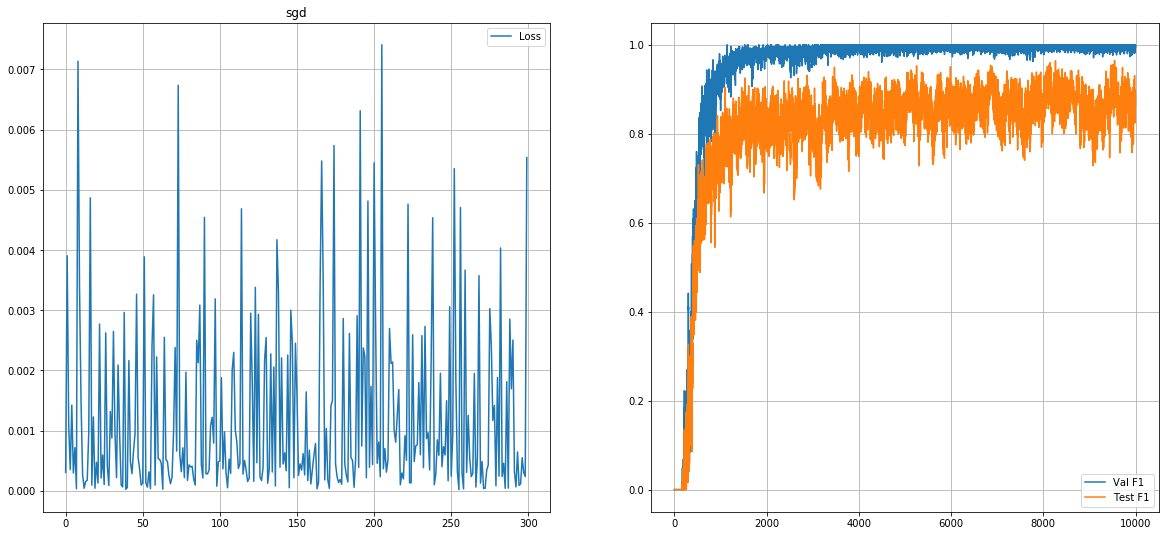

In [176]:
draw_res(train_ppl.v('loss'), val_score, test_score, 'sgd')

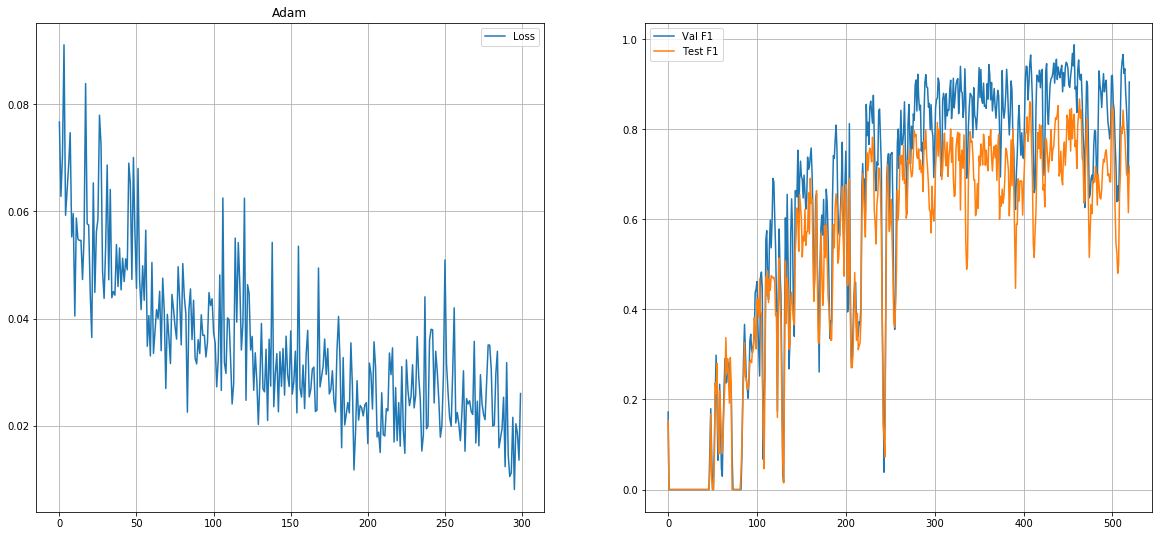

In [169]:
draw_res(train_ppl.v('loss'), val_score, test_score, 'Adam')

In [233]:
ppl_val = create_test_ppl(ppl_train, pal_data_te)
ppl_test = create_test_ppl(ppl_train, wz_data_te)

ppl_val.run(400, shuffle=True, drop_last=True, n_epochs=1, bar=True)
ppl_test.run(400, shuffle=True, drop_last=True, n_epochs=1, bar=True)



  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:00<00:33,  1.46it/s]

  4%|▍         | 2/50 [00:01<00:32,  1.48it/s]

  6%|▌         | 3/50 [00:02<00:31,  1.48it/s]

  8%|▊         | 4/50 [00:02<00:30,  1.52it/s]

 10%|█         | 5/50 [00:03<00:30,  1.50it/s]

 12%|█▏        | 6/50 [00:04<00:29,  1.47it/s]

 14%|█▍        | 7/50 [00:04<00:29,  1.47it/s]

 16%|█▌        | 8/50 [00:05<00:28,  1.48it/s]

 18%|█▊        | 9/50 [00:06<00:27,  1.48it/s]

 20%|██        | 10/50 [00:06<00:26,  1.49it/s]

 22%|██▏       | 11/50 [00:07<00:26,  1.47it/s]

 24%|██▍       | 12/50 [00:08<00:25,  1.47it/s]

 26%|██▌       | 13/50 [00:09<00:29,  1.24it/s]

 28%|██▊       | 14/50 [00:09<00:27,  1.30it/s]

 30%|███       | 15/50 [00:10<00:25,  1.35it/s]

 32%|███▏      | 16/50 [00:11<00:24,  1.38it/s]

 34%|███▍      | 17/50 [00:11<00:23,  1.40it/s]

 36%|███▌      | 18/50 [00:12<00:22,  1.44it/s]

 38%|███▊      | 19/50 [00:13<00:21,  1.44it/s]

 40%|████      | 20/50 [00:13<00:20,

In [234]:
print('Test traces, same dataset.')
get_results(ppl_val)

print('\n\nTest traces, another dataset.')
get_results(ppl_test)

Test traces, same dataset.
Number of inverse traces: 30104.0
Number of predict inverse traces: 29908
Number of missed inverse traces: 213.0
F1 : 0.9961674331800306


Test traces, another dataset.
Number of inverse traces: 30025.0
Number of predict inverse traces: 28635
Number of missed inverse traces: 2477.0
F1 : 0.9392430958063416


In [229]:
print('Test traces, same dataset.')
get_results(ppl_val)

print('\n\nTest traces, another dataset.')
get_results(ppl_test)

Test traces, same dataset.
Number of inverse traces: 61.0
Number of predict inverse traces: 88
Number of missed inverse traces: 0.0
F1 : 0.8187919463087248


Test traces, another dataset.
Number of inverse traces: 46.0
Number of predict inverse traces: 1097
Number of missed inverse traces: 2.0
F1 : 0.07699037620297462


In [228]:
def get_results(ppl):
    preds = np.array(np.array(ppl.v('pred')) > .5, dtype=int).ravel()
    labels = np.array(ppl.v('labels')).ravel()
    print('Number of inverse traces: {}'.format(sum(labels)))
    print('Number of predict inverse traces: {}'.format(sum(preds)))
    false_neg = sum(labels[np.where(labels != preds)])
    print('Number of missed inverse traces: {}'.format(false_neg))
    print('F1 : {}'.format(f1_score(labels, preds)))

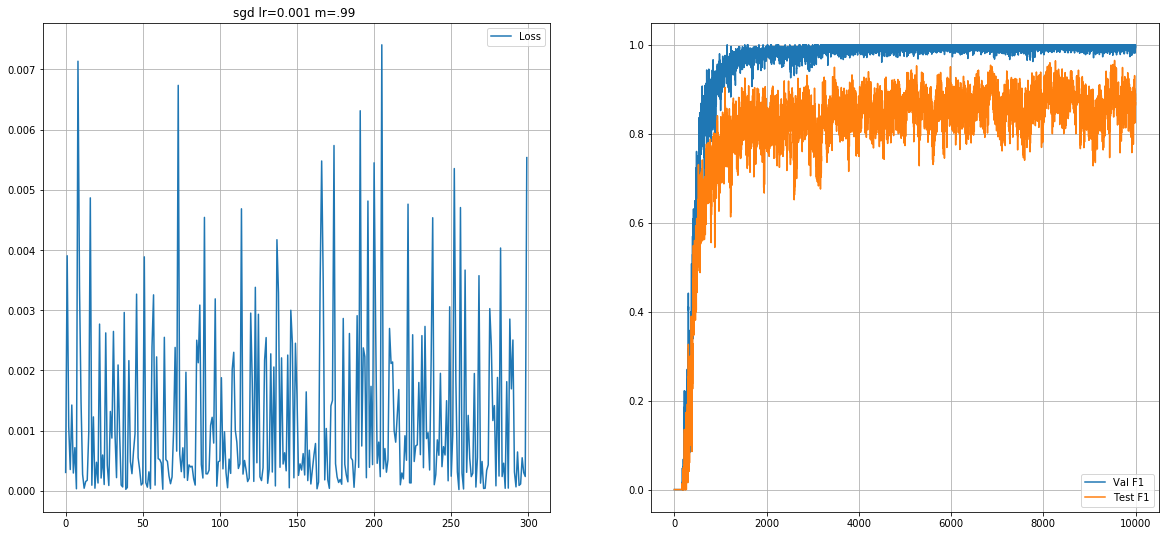

In [204]:
draw_res(train_ppl.v('loss'), val_score, test_score, 'sgd lr=0.001 m=.99 ')

In [168]:
def draw_res(loss, val_score, test_score, title):
    _, ax = plt.subplots(1, 2, figsize=(20, 9))
    ax[0].plot(loss[-300:], label='Loss')
    ax[1].plot(val_score, label='Val F1')
    ax[1].plot(test_score, label='Test F1')
    ax[0].set_title(title)
    ax[0].legend()
    ax[1].legend()
    ax[0].grid()
    ax[1].grid()
    plt.show()

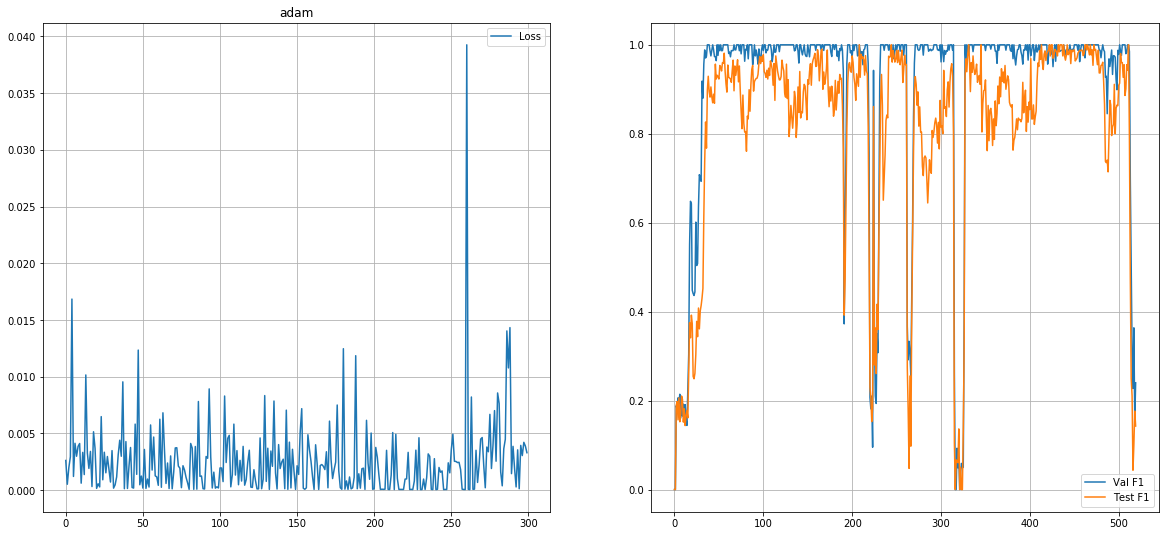

In [22]:
_, ax = plt.subplots(1, 2, figsize=(20, 9))
ax[0].plot(ppl_train.v('loss')[-300:], label='Loss')
ax[1].plot(val_score, label='Val F1')
ax[1].plot(test_score, label='Test F1')
ax[0].set_title('adam')
ax[0].legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()
plt.show()

In [ ]:
# ppl_val = (test_ppl << pal_data_te)
ppl_val.next_batch(400, shuffle=True, drop_last=True)

In [66]:
print(classification_report(labels_val, preds_val))
print(classification_report(labels_test, preds_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       356
           1       0.11      1.00      0.20        44

   micro avg       0.11      0.11      0.11       400
   macro avg       0.06      0.50      0.10       400
weighted avg       0.01      0.11      0.02       400

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       356
           1       0.11      1.00      0.20        44

   micro avg       0.11      0.11      0.11       400
   macro avg       0.06      0.50      0.10       400
weighted avg       0.01      0.11      0.02       400



In [8]:
BATCH_SIZE = 400
trained_models = []

for dts in datasets:
    config.update(dict(n_iters=len(dts.indices)/BATCH_SIZE))
    ppl = (train_ppl << dts)
    ppl.run(BATCH_SIZE, n_epochs=10, shuffle=True, drop_last=True, bar=True)
    trained_models.update(ppl.get_model_by_name('model').model)
    plt.plot(ppl.get_variable('loss'))
    b = (prep_ppl << dts).next_batch(400, shuffle=True)

    sigm = torch.nn.Sigmoid()
    inp = torch.Tensor(b.raw).to('cuda')
    out = sigm(trained_models[-1](inp))
    pred = np.array(out.cpu().detach().numpy()[:, 1]>.5, dtype=np.int32)
    target = b.labels

    print(classification_report(target, pred))

  8%|▊         | 164/2090 [01:24<15:54,  2.02it/s]

KeyboardInterrupt: 

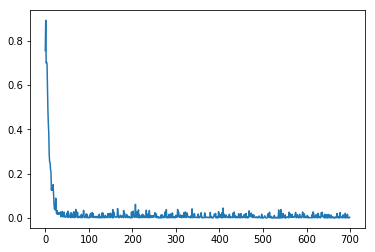

In [10]:
plt.plot(ppl.get_variable('loss'))

In [17]:
m = ppl.get_model_by_name('model').model

b = (prep_ppl << train_data).next_batch(400, shuffle=True)

import torch
sigm = torch.nn.Sigmoid()
inp = torch.Tensor(b.raw).to('cuda')
out = sigm(m(inp))

pred = np.array(out.cpu().detach().numpy()[:, 1]>.5, dtype=np.int32)

from sklearn.metrics import classification_report

target = b.labels

print(classification_report(target, pred))

In [14]:
pred_ppl = (Pipeline()
          .load(components='raw', fmt='segy')
          .standartize(src='raw', dst='raw')
          .inv_traces(src='raw', dst=['raw', 'labels'], p=0.0001)
          .import_model('model', ppl, 'model')
          .preprocess_component(src='raw', dst='raw')
          .preprocess_answers(src='labels', dst='labels')
          .init_variable('pred', init_on_each_run=list())
          .init_variable('labels', init_on_each_run=list())
          .update_variable('labels', B('labels'), mode='a') 
          .predict_model('model', B('raw'),
                         fetches='predictions',  save_to=V('pred', mode='a'))
) << pal_data_te

In [15]:
batch = pred_ppl.run(400, drop_last=True, shuffle=True, bar=True, n_epochs=1)

100%|██████████| 104/104 [00:37<00:00,  2.87it/s]


In [17]:
preds = np.array(np.concatenate(pred_ppl.get_variable('pred'))[:, 1] > .5, dtype=int)
labels = np.concatenate(pred_ppl.get_variable('labels'))

In [18]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     41598
           1       1.00      1.00      1.00         2

   micro avg       1.00      1.00      1.00     41600
   macro avg       1.00      1.00      1.00     41600
weighted avg       1.00      1.00      1.00     41600



In [19]:
print('Accuracy score: {:.3}'.format(accuracy_score(labels, preds)))
print('Number of inverse traces: {}'.format(sum(labels)))
print('Number of predict inverse traces: {}'.format(sum(preds)))
false_neg = sum(labels[np.where(labels != preds)])
print('Number of missed inverse traces: {}'.format(false_neg))

Accuracy score: 1.0
Number of inverse traces: 2
Number of predict inverse traces: 2
Number of missed inverse traces: 0


### Another dataset

In [23]:
!ls /data/FB/dataset_3

3_FBP_1k-ffid_3s.sgy	      3_FBP_1k-ffid_3s_pickingNN.csv
3_FBP_1k-ffid_3s_picking.csv  Vor_Flatiron_1K.sgy


In [24]:
path_raw = '/notebooks/egor/FB/Pal/Pal_Flatiron_1k.sgy'
trace_index = TraceIndex(name='raw', path=path_raw, extra_headers=['offset'])

In [25]:
test_index = TraceIndex(trace_index.create_subset(trace_index.indices[10000:40000]))
test_new_data = Dataset(test_index, InverseBatch)

In [26]:
pred_new_ppl = (Pipeline()
          .load(components='raw', fmt='segy')
          .standartize(src='raw', dst='raw')
          .inv_traces(src='raw', dst=['raw', 'labels'], p=0.001)
          .import_model('model', ppl, 'model')
          .preprocess_component(src='raw', dst='raw')
          .preprocess_answers(src='labels', dst='labels')
          .init_variable('pred', init_on_each_run=list())
          .init_variable('labels', init_on_each_run=list())
          .update_variable('labels', B('labels'), mode='a') 
          .predict_model('model', B('raw'),
                         fetches='predictions', 
                         save_to=V('pred', mode='a'))
) << test_new_data

In [27]:
pred_new_ppl.run(400, drop_last=True, shuffle=True, bar=True, n_epochs=1)

100%|██████████| 75/75 [00:21<00:00,  3.53it/s]


In [28]:
preds = np.array(np.concatenate(pred_new_ppl.get_variable('pred'))[:, 1] > .5, dtype=int)
labels = np.concatenate(pred_new_ppl.get_variable('labels'))

In [29]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29975
           1       1.00      1.00      1.00        25

   micro avg       1.00      1.00      1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000



In [30]:
print('Accuracy score: {:.3}'.format(accuracy_score(labels, preds)))
print('Number of inverse traces: {}'.format(sum(labels)))
print('Number of predict inverse traces: {}'.format(sum(preds)))
false_neg = sum(labels[np.where(labels != preds)])
print('Number of missed inverse traces: {}'.format(false_neg))

Accuracy score: 1.0
Number of inverse traces: 25
Number of predict inverse traces: 25
Number of missed inverse traces: 0


обучиться на двух и предсказать на третьем
другой подход? полтора д?
выравнивать трассы?


### Another dataset

In [51]:
path_inv = '/notebooks/egor/inverse_traces/2_prep_input_reverce_tr_check.sgy'
trace_index = TraceIndex(name='raw', path=path_inv, extra_headers=['offset'])

In [70]:
train_subset = np.random.choice(np.arange(trace_index.indices.shape[0]), 700000)
train_index = trace_index.create_subset(trace_index.indices[train_subset])
test_new_data = Dataset(TraceIndex((train_index)), InverseBatch)

In [31]:
pred_new_ppl = (Pipeline()
          .load(components='raw', fmt='segy', tslice=slice(1000))
          .drop_zero_traces(src='raw', num_zero=200)
          .normalize_traces(src='raw', dst='raw')
          .preprocess_component(src='raw', dst='raw')
          .init_model('dynamic', UNet, 'my_model', config=picking_config)
          .add_components('picking')
          .predict_model('my_model', B('raw'), fetches='predictions',  save_to=B('picking', mode='a'))
          .mask_to_pick(src='picking', dst='picking', labels=False)
          .crop_trace(src=['raw', 'picking'], dst='raw_cropped', size=SIZE)
          .normalize_traces(src='raw_cropped', dst='raw_cropped')
          .import_model('model', ppl, 'model')
          .preprocess_component(src='raw_cropped', dst='raw_cropped')
          .init_variable('pred', init_on_each_run=list())
          .predict_model('model', B('raw_cropped'),
                         fetches='predictions',  save_to=V('pred', mode='a'))
) << test_new_data

NameError: name 'UNet' is not defined

In [32]:
batch = pred_new_ppl.run(400, drop_last=True, shuffle=True, bar=True, n_epochs=1)

100%|██████████| 75/75 [00:21<00:00,  3.48it/s]


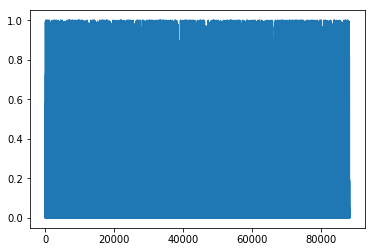

In [55]:
preds = np.array(np.concatenate(pred_new_ppl.get_variable('pred'))[:, 1] > .5, dtype=int)
pred_proba = np.array(np.concatenate(pred_new_ppl.get_variable('pred')))
# labels = np.concatenate(pred_new_ppl.get_variable('labels'))

plt.plot(sigm(torch.Tensor(pred_proba[:, 1])).cpu().detach().numpy())
# plt.ylim(0.3575, 0.362)
# plt.scatter(np.arange(len(labels)), labels)

In [40]:
print(np.sum(preds), len(preds))

2186 88400


(array([86217.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  2183.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

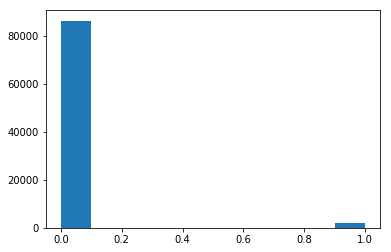

In [56]:
plt.hist(preds)